In [292]:
%cd C:\Users\yukir\Documents\GitHub\Text_Mining\py

from nlp_processing import *
set_global_determinism(seed=1337)

%cd C:\Users\yukir\Documents\Monicas_workspace\Dental\LDA

C:\Users\yukir\Documents\GitHub\Text_Mining\py
C:\Users\yukir\Documents\Monicas_workspace\Dental\LDA


In [293]:
from gensim.models.ldamodel import LdaModel 
from gensim.models.callbacks import CoherenceMetric 
from gensim import corpora 
from gensim.models.callbacks import PerplexityMetric 
import logging 
import pickle 
import pyLDAvis

from gensim.models.coherencemodel import CoherenceModel 
import matplotlib.pyplot as plt

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

from konlpy.tag import Mecab 
from konlpy.tag import Okt
okt = Okt()
from tqdm import tqdm 
import re 
import pickle 
import csv

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from gensim import corpora, models
from gensim.models import CoherenceModel
import gensim
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import re, nltk, spacy, gensim

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [294]:
def clean_text(text): 
    """ 한글, 영문, 숫자만 남기고 제거한다. 
    :param text: 
    :return: 
    """ 
    text = text.replace(".", " ").strip() 
    text = text.replace("·", " ").strip() 
    pattern = '[^ ㄱ-ㅣ가-힣|0-9|a-zA-Z]+' 
    text = re.sub(pattern=pattern, repl='', string=text) 
    return text 
    
def get_nouns(tokenizer, sentence): 
    """ 단어의 길이가 2이상인 일반명사(NNG),
     고유명사(NNP), 외국어(SL)만을 반환한다. 
     :param tokenizer: 
     :param sentence: :return: """ 
    tagged = tokenizer.nouns(sentence)
    nouns = [s for s in tagged if len(s)>1] 
     
    return nouns 
     
     
def tokenize(df): 
    tokenizer = okt
    processed_data = [] 
    for sent in tqdm(df['cleaned_reviews']):
        sentence = clean_text(sent.replace('\n', '').strip()) 
        processed_data.append(get_nouns(tokenizer, sentence)) 
        
    return processed_data
    
    
def save_processed_data(processed_data): 
    """ 토큰 분리한 데이터를 csv로 저장 :param processed_data: :return: """ 
    
    with open('lsa_token_neg.csv', 'w', newline='', encoding='utf-8') as f: 
        writer = csv.writer(f) 
        for data in processed_data:
             writer.writerow(data)

In [295]:
dental_pos = pd.read_csv('dental_neg.csv', index_col=0)
df = dental_pos.copy()

{'whiskers': [<matplotlib.lines.Line2D at 0x22ca3a2d4c0>,
 'caps': [<matplotlib.lines.Line2D at 0x22ca3a2dac0>,
 'boxes': [<matplotlib.lines.Line2D at 0x22ca3a2d130>],
 'medians': [<matplotlib.lines.Line2D at 0x22ca3a47220>],
 'fliers': [<matplotlib.lines.Line2D at 0x22ca3a475b0>],
 'means': []}

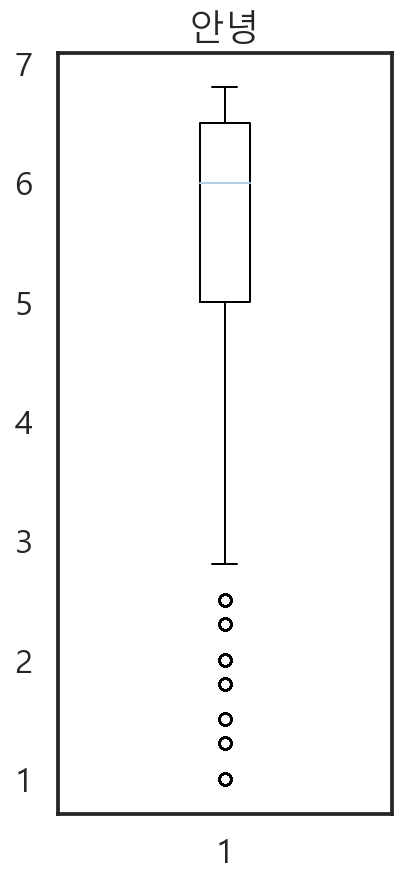

In [296]:
plt.figure(figsize = (3,7))
plt.rc('font', family='Malgun Gothic') 
%config InlineBackend.figure_format = 'retina'
plt.title("안녕")
plt.boxplot(df['stars'])

## **TOKENIZING**

In [297]:
print(len(df))
df = df.dropna()
print(len(df))
df = df.drop_duplicates('cleaned_reviews')
print(len(df))
df = df.drop_duplicates('cleaned_reviews')
print(len(df))

8456
8352
2763
2763


In [298]:
for sent in tqdm(df['cleaned_reviews']):
    try:
        sentence = clean_text(sent.replace('\n', '').strip())
        # print(sentence)
    except:
        print(sent)
        pass

100%|██████████| 2763/2763 [00:00<00:00, 184254.36it/s]


In [299]:
## 오래걸리니까 조심

if __name__ == '__main__':
     # df = pd.read_csv('negative.csv', index_col = 0)
     processed_data = tokenize(df) # description 부분을 토크나이징 한다. 
     
     # 토큰 분리한 데이터를 저장 
     save_processed_data(processed_data)


100%|██████████| 2763/2763 [01:00<00:00, 45.69it/s]


## **TF-IDF**

In [301]:
detokenized_doc = []
for i in range(len(processed_data)):
    t = ' '.join(processed_data[i])
    detokenized_doc.append(t)

df['detokenized_doc'] = detokenized_doc # 다시 text['headline_text']에 재저장

df['detokenized_doc'][:5]

32    사랑니 발치 위아래 설명 직원 친절 개선 소독 두번째 방문 설명 전혀 소독 진료 바...
36    매복 사랑니 발치 사랑니 발치 겸사겸사 충치 검진 기선 과잉 진료 사랑니 과잉 진료 기분
37    환자 대한 배려 병원 마취 정말 사랑니 여기 절대 가지 가지 여기 치과 마취 시간 ...
39    고통 사랑니 발치 사랑니 병원 사랑니 공장 느낌 사랑니 자연 원인 설명 그냥 마취 ...
45    전문 주의 사항 사랑니 공장 우리나라 제일 대서 방문 기대 만족 우선 예약 불구 대...
Name: detokenized_doc, dtype: object

In [446]:
from nltk.corpus import stopwords  
stopwords.words('korean')[:10] 

stopwords_kor = stopwords.words('korean')

In [447]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=stopwords_kor,             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[가-힣0-9]{1,}',  # num chars > 3
                             max_features=2000,             # max number of uniq words
                            ) 
data_vectorized = vectorizer.fit_transform(df['detokenized_doc'])
data_vectorized.shape # TF-IDF 행렬의 크기 확인

(2763, 726)

In [448]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.245283752538713 %


In [449]:
from sklearn.decomposition import LatentDirichletAllocation
lda_model=LatentDirichletAllocation(n_components=3,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=1337,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_top=lda_model.fit_transform(data_vectorized)

print(lda_model.components_)
print(lda_model.components_.shape) 

[[ 2.4865525  24.03915601  0.35050073 ... 12.5776022   0.67917436
   8.60490697]
 [ 2.01264599  6.14418105  1.71398942 ...  0.38396823  7.27175063
   0.38309806]
 [11.30805225 50.9781302   2.81328456 ...  0.35238112  9.88212995
   0.52586056]]
(3, 726)


In [450]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -63441.5066061268
Perplexity:  660.2506698875895
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 3, 'n_jobs': -1, 'perp_tol': 0.1, 'random_state': 1337, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [451]:
# # Define Search Param
# search_params = {'n_components': [3, 5 , 6, 7], 'learning_decay': [.5, .7, .9]}

# # Init the Model
# lda = LatentDirichletAllocation()

# # Init Grid Search Class
# model = GridSearchCV(lda, param_grid=search_params)

# # Do the Grid Search
# model.fit(data_vectorized)

In [452]:
# # Best Model
# best_lda_model = model.best_estimator_

# # Model Parameters
# print("Best Model's Params: ", model.best_params_)

# # Log Likelihood Score
# print("Best Log Likelihood Score: ", model.best_score_)

# # Perplexity
# print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

## **OUTPUT**

In [453]:
# Create Document - Topic Matrix
lda_output = lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(df['cleaned_reviews'].tolist()))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.120000,0.790000,0.090000,1
Doc1,0.090000,0.480000,0.430000,1
Doc2,0.090000,0.820000,0.090000,1
Doc3,0.160000,0.750000,0.090000,1
Doc4,0.060000,0.860000,0.080000,1
Doc5,0.100000,0.510000,0.390000,1
Doc6,0.100000,0.790000,0.120000,1
Doc7,0.070000,0.740000,0.180000,1
Doc8,0.530000,0.340000,0.130000,0
Doc9,0.070000,0.840000,0.080000,1


In [454]:
terms = vectorizer.get_feature_names() # 단어 집합. 1,000개의 단어가 저장됨.

def get_topics(components, feature_names, n=10):
    for idx, topic in enumerate(components):
        print("Topic %d:" % (idx+1), [(feature_names[i], topic[i].round(2)) for i in topic.argsort()[:-n - 1:-1]])
get_topics(lda_model.components_,terms)

Topic 1: [('교정', 129.68), ('상담', 56.18), ('진료', 54.54), ('예약', 50.94), ('치료', 48.7), ('원장', 48.22), ('설명', 46.66), ('치과', 37.13), ('직원', 36.73), ('병원', 35.22)]
Topic 2: [('사랑니', 94.27), ('발치', 79.64), ('마취', 41.19), ('병원', 36.75), ('치료', 35.36), ('의사', 34.07), ('치과', 29.92), ('환자', 29.83), ('통증', 29.62), ('진료', 28.55)]
Topic 3: [('치료', 179.2), ('스케일링', 165.69), ('치과', 127.68), ('진료', 121.71), ('충치', 120.8), ('방문', 107.52), ('병원', 92.58), ('의사', 84.77), ('선생님', 82.69), ('치아', 80.62)]


In [455]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, data_vectorized, vectorizer, mds='tsne')
panel

C:\Users\yukir\anaconda3\envs\NLP\lib\site-packages\pyLDAvis\_prepare.py:228: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info  = pd.DataFrame({'saliency': saliency, 'Term': vocab, \
C:\Users\yukir\anaconda3\envs\NLP\lib\site-packages\sklearn\manifold\_t_sne.py:691: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


PreparedData(topic_coordinates=                 x            y  topics  cluster       Freq
topic                                                      
2     -1015.700562  1338.981201       1        1  45.388606
0      -387.996002  -373.316162       2        1  29.163014
1     -2184.745605   -60.565800       3        1  25.448380, topic_info=     Term        Freq       Total Category  logprob  loglift
67     교정  127.000000  127.000000  Default  30.0000  30.0000
287   사랑니   94.000000   94.000000  Default  29.0000  29.0000
335  스케일링  146.000000  146.000000  Default  28.0000  28.0000
234    발치   80.000000   80.000000  Default  27.0000  27.0000
639    충치  110.000000  110.000000  Default  26.0000  26.0000
..    ...         ...         ...      ...      ...      ...
440    원장   16.420936   97.611018   Topic3  -5.0201  -0.4139
235    방문   16.898620  128.682073   Topic3  -4.9915  -0.6616
14    간호사   15.660246   76.539107   Topic3  -5.0676  -0.2182
614    처음   14.398191   47.620407   Topic3  -5.1516   0.1724
415    예약   15.532376  107.554827   Topic3  -5.0758  -0.5666

[208 rows x 6 columns], token_table=      Topic      Freq Term
term                      
1         1  0.604708   가격
1         2  0.309073   가격
1         3  0.080628   가격
5         3  0.892971   가라
14        1  0.561804  간호사
...     ...       ...  ...
722       1  0.900478   회사
722       2  0.075040   회사
722       3  0.075040   회사
723       2  0.924450   효과
725       2  0.864765   후회

[268 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2])

In [456]:
df_document_topic.to_csv('LDA_tfidf_neg.csv')

In [457]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,2,1464
1,0,726
2,1,573


In [458]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,가게,가격,가글,가까이,가도,가라,가량,가세,가시,가야,가요,가장,가족,간다,간호사,간호조무사,감사,감안,강남,강요,강조,개선,개원,개월,개인,갯수,거나,거리,거부,거울,걱정,건강,건강검진,건물,검사,검색,검진,견적,결과,결론,결정,결제,경과,경력,경험,계산,계시,계획,고객,고려,...,퇴근,특성,티비,파노라마,파서,판단,평가,평균,평생,평소,평일,포함,표정,프로,프론트,플린트,피씨,필요,하니,하라,하루,하자,하진,학교,학생,한번,한숨,한적,한지,한쪽,한참,한편,할인,합리,항상,해결,해당,현재,홈페이지,홍보,화가,화장실,확인,환경,환불,환자,회사,효과,후기,후회
Topic0,2.486552,24.039156,0.350501,2.588525,5.723016,0.357536,3.215620,5.299278,0.374419,9.849228,3.710014,4.960715,0.486184,0.423140,17.822461,0.896893,4.377711,0.404318,10.040963,0.371056,0.362839,7.883163,1.500235,1.150297,8.807640,0.357732,1.727524,2.751211,1.881435,0.464897,6.359432,0.947991,0.340906,5.597571,9.846274,0.397956,0.953804,0.353824,15.594452,2.148435,3.588898,6.800509,2.779761,0.370381,1.651485,0.375057,0.429393,2.353301,0.910559,2.412334,...,2.098467,3.593501,2.211344,0.391216,2.003348,0.488075,4.569478,0.479482,2.622520,3.670520,1.644857,4.251270,3.370822,3.681195,2.526376,5.909665,3.651644,2.038780,1.327180,0.481311,1.582471,0.362264,1.892180,0.378417,2.103808,11.549511,4.581918,1.447493,3.508411,0.345290,5.373573,7.697149,5.152649,2.817017,29.388925,9.504018,0.365909,3.944619,3.969728,3.196110,0.516427,9.334251,1.260368,3.964815,3.638516,28.365557,0.520781,12.577602,0.679174,8.604907
Topic1,2.012646,6.144181,1.713989,0.715987,4.494882,9.263675,0.420856,0.766032,0.838317,3.496685,0.350060,3.571328,0.387415,2.662735,15.698411,0.454846,0.372106,3.668888,0.347816,0.924167,0.924583,1.451562,0.677399,2.072261,6.730332,0.353912,0.934271,3.442268,0.583112,1.257741,6.549730,0.351054,0.344359,0.438281,3.891593,5.978123,0.443319,0.365595,3.912002,5.509313,12.314527,0.402154,6.601785,7.285173,9.336896,1.115028,0.354761,1.920352,1.215934,1.081667,...,3.838176,0.389728,0.421319,1.156328,1.649531,1.343490,0.382434,9.630313,0.696202,1.076882,3.532823,2.341230,0.450441,0.389125,0.375550,0.356925,0.335562,0.827822,3.802979,2.568734,4.336963,2.098532,0.507739,3.726452,2.054432,3.055206,0.418667,2.196341,0.511480,3.485619,2.732513,0.422562,0.363017,0.637863,0.372634,1.321450,2.980065,0.449155,0.369122,0.388504,0.458663,0.396086,5.570712,0.366215,0.480970,29.825461,0.823688,0.383968,7.271751,0.383098
Topic2,11.308052,50.978130,2.813285,4.168360,4.481585,0.555582,1.309512,3.003556,3.406540,1.907070,0.375884,5.434613,8.386216,2.965445,49.459777,8.488185,0.351481,0.355176,0.369740,7.290856,2.324307,0.453973,3.630893,10.264279,2.845894,4.219978,3.060967,7.817670,2.849022,4.492672,7.760944,5.134539,13.743528,20.769435,15.425976,12.732288,72.349290,24.156881,14.671504,0.802025,0.769215,5.691589,0.387713,0.584850,0.357408,4.247834,4.509854,3.201811,5.487440,0.360588,...,0.491356,0.488540,3.085997,3.629015,0.398662,5.392295,0.392007,0.853433,0.385793,5.002678,6.014681,0.694559,1.645357,0.376769,1.910053,0.342803,0.340286,9.737169,8.037917,11.173119,0.375676,4.195946,1.845757,0.401793,0.374689,24.273968,0.808656,0.413364,5.324715,0.383380,1.769532,0.714812,4.770509,9.195423,0.669573,0.476424,4.920172,7.346431,0.358681,0.425431,4.621891,0.387786,23.167860,3.238655,0.367996,23.188808,13.649695,0.352381,9.882130,0.525861


In [459]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,교정,상담,진료,예약,치료,원장,설명,치과,직원,병원,의사,항상,대기,선생님,환자
Topic 1,사랑니,발치,마취,병원,치료,의사,치과,환자,통증,진료,설명,선생님,신경치료,잇몸,염증
Topic 2,치료,스케일링,치과,진료,충치,방문,병원,의사,선생님,치아,검진,과잉,설명,직원,가격


In [460]:
a = df_document_topic.dominant_topic.tolist()

In [461]:
df['dominant_topic'] =a
df.head()

,hospital,reviews,stars,address,add_clean,cleaned_reviews,detokenized_doc,dominant_topic
32,잎사귀치과병원,사랑니 발치 위아래 5분정도 걸린 거 같아요 빨리 뽑은 건 만족합니다 그러나 자세한...,5.8,서울 서대문구 신촌동,서울,사랑니 발치 위아래 5분정도 걸린 거 같아요 빨리 뽑은 건 만족합니다 그러나 자세한...,사랑니 발치 위아래 설명 직원 친절 개선 소독 두번째 방문 설명 전혀 소독 진료 바...,1
36,잎사귀치과병원,매복이 아닌 사랑니 2개 발치했습니다. 사랑니는 너무 깔끔하게 잘 발치해서 겸사겸사...,6.5,서울 서대문구 신촌동,서울,매복이 아닌 사랑니 2개 발치했습니다 사랑니는 너무 깔끔하게 잘 발치해서 겸사겸사...,매복 사랑니 발치 사랑니 발치 겸사겸사 충치 검진 기선 과잉 진료 사랑니 과잉 진료 기분,1
37,잎사귀치과병원,한줄평: 환자에 대한 배려가 부족한 병원. 마취 정말 짧게해요아픈거 무서워서 사랑니...,1.0,서울 서대문구 신촌동,서울,환자에 대한 배려가 부족한 병원 마취 정말 짧게해요아픈거 무서워서 사랑니 잘 뽑...,환자 대한 배려 병원 마취 정말 사랑니 여기 절대 가지 가지 여기 치과 마취 시간 ...,1
39,잎사귀치과병원,한줄평: 고통을 느끼지 못한 완벽한 사랑니 발치사랑니를 발치러 갔는데 병원이라기보다...,6.8,서울 서대문구 신촌동,서울,고통을 느끼지 못한 완벽한 사랑니 발치사랑니를 발치러 갔는데 병원이라기보다 사랑니...,고통 사랑니 발치 사랑니 병원 사랑니 공장 느낌 사랑니 자연 원인 설명 그냥 마취 ...,1
45,잎사귀치과병원,한줄평: 전문적이지만 좀 대충대충임. 주의사항 잘 안 알려줌사랑니 공장으로 우리나라...,5.5,서울 서대문구 신촌동,서울,전문적이지만 좀 대충대충임 주의사항 잘 안 알려줌사랑니 공장으로 우리나라에서 제...,전문 주의 사항 사랑니 공장 우리나라 제일 대서 방문 기대 만족 우선 예약 불구 대...,1


In [462]:
df.to_csv('final_dental_neg.csv')

In [495]:
less_6 = df[df['stars']<3]

for i in less_6[less_6['dominant_topic']==1]['cleaned_reviews']:
    # print('-', i)
    if '예약'in i:
        print('-', i)

-  환자에 대한 배려가 부족한 병원  마취 정말 짧게해요아픈거 무서워서 사랑니 잘 뽑는곳 찾으시는 분들 여기 절대 가지마세요 정말로 가지 마세요 여기 안아프게 뽑아주는곳이 아니라 아프게 빨리 뽑는 치과입니다  마취하고 시간을 안준다는 후기를 봐서 저 좀 오래 있다가 뽑고싶다고 말씀까지 드렸는데도 5분 지나니까 바로 뽑아버리셨어요 아래쪽 사랑니 뽑는데 저같은 으른겁쟁이는 눈앞이 새하얘지는 고통이었습니다 진짜 겁쟁이들 어디가서 엄살 좀 부린다 하는 사람들 절대   절대   진짜 절대 가지마요 원장선생님께는 특히 뽑힘당하지 마세요 너무 능숙하셔서 환자 고통이고 자시고 사랑니 쏙쏙 뽑는거에만 집중하신다구요 여러분 진짜 아파요 여기 엄청 아파요 동네병원 가서 마취받고 찬찬히 뽑으세요 사랑니뽑고 귀가하는길 겁쟁이들을 위해 리뷰를 남깁니다 겁쟁이들 여기 얼씬도 하지마세요 예약하고 방문해도 1020분은 대기해요 대기실에 의자도 부족해서 서서 기다려야 하고 발치하고 약받는것도 다시 내려와서 10분은 기다려야하네요 휴
- 사랑니 전문 치과라고 해서 믿고 다녀왔습니다 오른쪽의 사랑니를 뽑고 얼굴이 많이 부었고 붓기가 3주가 다되도록 빠지지 않더라고요  볼쪽에 멍도 있었고요  안쪽이 너무 심하게 부어 있어서 이빨과 이빨이 서로 닿을수가 없었고 2주동안 죽만 먹었습니다 그뒤 예약상 문제로 다른 치과에 가서 사랑니를 뽑기로 하였고 엑스레이를 찍은 결과 이 잎사귀 치과에서 뽑은 사랑니 조각들이 많이 남아 있었습니다 왼쪽 사랑니 발치를 하게된 치과에서 사랑니가 온전히 다 뽑히지 않을거 알았냐 물었고 보통 사랑니 이빨이 남은경우  남겨두었다고 공지를 하거나 혹시나의 상황에 대비해 엑스레이를 한번 더 찍는 다고 하더군요 하지만 전 공지를 받거나 엑스레이를 한번더 찍진 않았습니다  다시 잎사귀 치과에 와서 엑스레이를 찍고 대표원장님을 한번 만났습니다  대표원장이라는 분이 제 엑스레이 사진을 보더니 어느 치과에서 이빨을 이렇게 뽑았냐고 되래 묻더군요 ㅎㅎ 치위생사로 보이는 한분이 저희 병원에서